# Loading & Preprocessing

In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.metrics import SparseCategoricalAccuracy, CategoricalAccuracy
from keras.applications.resnet import ResNet50
from keras.applications.resnet import ResNet152
from keras.applications.densenet import DenseNet201
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import adam_v2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score, average_precision_score, roc_auc_score, mean_squared_error, f1_score, confusion_matrix
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools

import os 
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.chdir('/content/drive/MyDrive/WIKM')

### Load Bone

In [4]:
X_train = np.load('X_train_bone.npy')
Y_train = np.load('Y_train_bone.npy')

In [5]:
# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train= X_train[s]
Y_train = Y_train[s]

### Load Lung

In [ ]:
#Load arrays RAW

X_train_raw = np.load('X_train_raw.npy')
Y_train_raw = np.load('Y_train_raw.npy')

In [ ]:
#from patches

X_train = np.load('X_train_lung.npy')
Y_train = np.load('Y_train_lung.npy')
X_test = np.load('X_test_lung.npy')
Y_test = np.load('Y_test_lung.npy')

In [ ]:
# Shuffle train data

s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

In [ ]:
# Shuffle train data RAW

s = np.arange(X_train_raw.shape[0])
np.random.shuffle(s)
X_train_raw = X_train_raw[s]
Y_train_raw = Y_train_raw[s]

In [ ]:
# Shuffle test data

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

### Train and Evaluation Split

In [6]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train_raw, Y_train_raw, 
    test_size=0.2, 
    random_state=11
)

# Data Generator

In [7]:
BATCH_SIZE = 20

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

#using above generator makes ram explode 

In [8]:
optimizer = adam_v2.Adam(learning_rate=1e-4)

def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(3, activation='softmax'))
    
    
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    
    return model

### ResNet 152

In [ ]:
K.clear_session()
gc.collect()

densenet = ResNet152(
    weights='imagenet',
    include_top=False,
    input_shape=(256,256,3)
)


 


model = build_model(densenet ,lr = 1e-4)
model.summary()

### Model: Plain CNN

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, Activation, GlobalAveragePooling2D
from keras import regularizers
from tensorflow.keras.optimizers import Adam

image_size = 224


model = Sequential()
model.add(Conv2D(16, kernel_size=3, activation='relu', padding='same', input_shape=(224, 224, 3)))
model.add(Conv2D(16, kernel_size=3, activation='relu', padding='same'))
model.add(Conv2D(16, kernel_size=3, activation='relu', padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
model.add(Conv2D(32, kernel_size=3, activation='relu', padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
#model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(0.01)))
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
#model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
#model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer= tf.keras.regularizers.l2(0.01)))
model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
#model.add(Conv2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.35))
model.add(Flatten())
#model.add(Dense(256, activation='relu', kernel_regularizer= tf.keras.regularizers.l2(0.01)))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(128, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(Dense(3, activation='softmax'))
model.summary()

In [ ]:
model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    

# Model: DenseNet201

In [ ]:
K.clear_session()
gc.collect()

densenet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


 


model = build_model(densenet ,lr = 1e-4)
model.summary()

### Inception V3

In [12]:
K.clear_session()
gc.collect()

densenet = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


 


model = build_model(densenet ,lr = 1e-4)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 21,817,123
Trainable params: 21,778,595
No

###VGG19

In [9]:
K.clear_session()
gc.collect()

densenet = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


 


model = build_model(densenet ,lr = 1e-4)
model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 3)                 1539      
                                                         

# VGG16


In [ ]:
K.clear_session()
gc.collect()

densenet = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


 


model = build_model(densenet ,lr = 1e-4)
model.summary()

# ResNet50

In [ ]:
K.clear_session()
gc.collect()

resnet50 = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(256,256,3)
)


 


model = build_model(resnet50 ,lr = 1e-4)
model.summary()



94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                         

In [10]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_loss', patience =8,
                                  verbose=1,factor=0.1, min_lr=1e-7)

# Checkpoint
filepath="vgg19.bone.best.raw.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10, mode='min')

# Training & Evaluation

In [11]:
### bone model.fit

with tf.device('/device:GPU:0'):
  history = model.fit( x = x_train, y = y_train, batch_size=BATCH_SIZE,
      steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
      epochs=100,
      validation_steps = x_val.shape[0] / BATCH_SIZE,
      validation_data=(x_val, y_val),
      callbacks=[learn_control, checkpoint])

Epoch 1/100
42/41 [==============================] - ETA: 0s - loss: 0.9215 - accuracy: 0.5719
Epoch 1: val_accuracy improved from -inf to 0.65550, saving model to vgg19.bone.best.raw.hdf5
41/41 [==============================] - 26s 328ms/step - loss: 0.9215 - accuracy: 0.5719 - val_loss: 1.4337 - val_accuracy: 0.6555 - lr: 1.0000e-04
Epoch 2/100
42/41 [==============================] - ETA: 0s - loss: 0.6178 - accuracy: 0.7590
Epoch 2: val_accuracy improved from 0.65550 to 0.75120, saving model to vgg19.bone.best.raw.hdf5
41/41 [==============================] - 9s 228ms/step - loss: 0.6178 - accuracy: 0.7590 - val_loss: 0.7393 - val_accuracy: 0.7512 - lr: 1.0000e-04
Epoch 3/100
42/41 [==============================] - ETA: 0s - loss: 0.5136 - accuracy: 0.8141
Epoch 3: val_accuracy improved from 0.75120 to 0.80861, saving model to vgg19.bone.best.raw.hdf5
41/41 [==============================] - 9s 228ms/step - loss: 0.5136 - accuracy: 0.8141 - val_loss: 0.6163 - val_accuracy: 0.8086

In [ ]:
### lung model.fit

with tf.device('/device:GPU:0'):
  history = model.fit( x = x_train, y = y_train, batch_size=BATCH_SIZE,
      steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
      epochs=100,
      validation_steps = x_val.shape[0] / BATCH_SIZE,
      validation_data=(x_val, y_val),
      callbacks=[learn_control, checkpoint])

Epoch 1/100
243/242 [==============================] - ETA: 0s - loss: 0.4853 - accuracy: 0.8271
Epoch 1: val_accuracy improved from -inf to 0.84432, saving model to resnet50.lung.best.raw.hdf5
242/242 [==============================] - 90s 297ms/step - loss: 0.4853 - accuracy: 0.8271 - val_loss: 0.4032 - val_accuracy: 0.8443 - lr: 1.0000e-04
Epoch 2/100
243/242 [==============================] - ETA: 0s - loss: 0.2673 - accuracy: 0.9042
Epoch 2: val_accuracy did not improve from 0.84432
242/242 [==============================] - 69s 286ms/step - loss: 0.2673 - accuracy: 0.9042 - val_loss: 1.1857 - val_accuracy: 0.7891 - lr: 1.0000e-04
Epoch 3/100
243/242 [==============================] - ETA: 0s - loss: 0.2037 - accuracy: 0.9293
Epoch 3: val_accuracy improved from 0.84432 to 0.85997, saving model to resnet50.lung.best.raw.hdf5
242/242 [==============================] - 72s 299ms/step - loss: 0.2037 - accuracy: 0.9293 - val_loss: 0.4532 - val_accuracy: 0.8600 - lr: 1.0000e-04
Epoch 4/

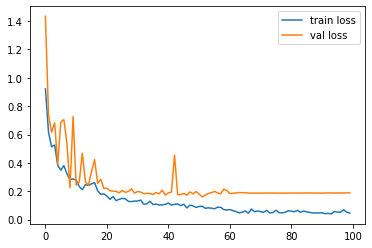

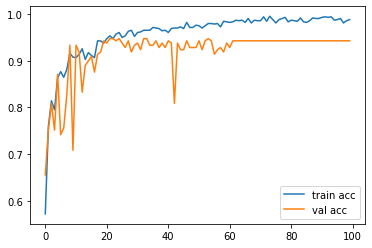

In [12]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [ ]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['acc', 'val_acc']].plot()

In [ ]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [ ]:
X_train.shape

# Prediction

In [ ]:
model.load_weights("resnet50.lung.best.raw.hdf5")

In [ ]:
Y_val_pred = model.predict(x_val)

In [ ]:
Y_val_pred.shape

(1214, 3)

In [ ]:
x_val.shape

(1214, 256, 256, 3)

In [ ]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

ValueError: ignored

In [ ]:
confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

In [ ]:
rawPatch = np.load('rawPatch.npy')

In [ ]:
rawPatch.shape

(256, 256, 3)